# 의사결정나무 분류 모델 하이퍼파라미터 튜닝

## 데이터전처리(~2022)

In [2]:
import pandas as pd

# # date Feature를 '월'로 변경(1월 ~ 12월)하는 함수
def date_to_month(df):
    df['month'] = df.index.str.slice(5, 7).astype(int)
    return df.drop(['date'], axis=1)

# Month Feature를 추가하고 데이터를 섞어서 전처리하는 함수
def df_preprocessing(X, y):
    df_data = X
    df_label = y
    # date Feature를 '월'로 변경(1월 ~ 12월)
    df_data['month'] = df_data.index.str.slice(5, 7).astype(int)
    df_data = df_data.drop(['date'], axis=1)
    # 인덱스 제거(label과 합치기 위해)
    df_data.reset_index(drop=True, inplace=True)
    # 인덱스 제거(data와 합치기 위해)
    df_label.reset_index(drop=True, inplace=True)
    # data와 label을 합침
    df = pd.concat([df_data, df_label], axis=1)
    # 데이터프레임 행 셔플
    df = df.sample(frac=1).reset_index(drop=True)
    # 이상치로 예상되는 데이터 제거
    df = df[df['mode'] != 2]
    # 만약 라벨이 카테고리화되어 있으면(라벨의 컬럼명이 'top')
    try:
        # 다시 입력값(데이터)와 결과값(라벨)을 분리하여 리턴
        return df.drop(['top'], axis=1), df[['top']]
    # 만약 라벨이 카테고리화되어 있지 않으면(라벨의 컬럼명이 '0')
    except KeyError:
        # 다시 입력값(데이터)와 결과값(라벨)을 분리후 라벨을 카테고리화하여 리턴
        return df.drop(['0'], axis=1), ((df[['0']] - 1) // 10) * 10 + 10

In [3]:
import pandas as pd

# 데이터 받아오기
data = pd.read_csv('../data/dataframes/dataframe_final.csv', index_col=0)
label = pd.read_csv('../data/dataframes/label_categorized_final.csv', index_col=0)

In [4]:
# 데이터 전처리
X, y = df_preprocessing(data, label)

In [5]:
# 훈련 데이터와 테스트 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## 2023년 데이터 생성

In [6]:
# 2023년도 데이터 받아오기
data2023 = pd.read_csv('../data/dataframes/dataframe_2023to2023.csv', index_col=0)
label2023 = pd.read_csv('../data/dataframes/label_2023to2023.csv', index_col=0)

In [7]:
# 2023년도 데이터 전처리
X_2023, y_2023 = df_preprocessing(data2023, label2023)

In [8]:
# 라벨을 데이터프레임에서 1차원 배열로 재배열
y_train_label = y_train.values.reshape(-1)
y_test_label = y_test.values.reshape(-1)
y_2023_label = y_2023.values.reshape(-1)

## 모델 학습 및 시각화 함수 구현(똑같음)

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# matplotlib 한글 패치
font_name = font_manager.FontProperties(fname='c:/windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

# 예측값과 실제값을 시각화하는 함수
def pred_visualize(pred, real, title):
    plt.figure(figsize=(20, 6))
    plt.plot(pred, label="Predicted")
    plt.plot(real, label="Real")
    plt.legend()
    plt.show()

# 모델 정확도 및 시각화 함수
def model_fit_and_visualize(model, name = '모델'):
    print(name, '학습 중')
    
    # 모델 학습
    model.fit(X_train, y_train_label)
    model_pred = model.predict(X_test)

    # ~2022년도 분류 모델 성능 출력
    print(name, '기존 데이터 정확도 :', model.score(X_test, y_test_label))

    # ~2022년도 데이터 예측값과 실제값 비교 시각화
    pred_visualize(model_pred[:50], y_test_label[:50], name + ' 기존 데이터 50개 샘플 예측 시각화')

    # 2023년도 분류 모델 성능 출력
    print(name, '2023년 데이터 정확도 :', model.score(X_2023, y_2023_label))

    # 2023년도 모델 예측값 생성
    model_pred_2023 = model.predict(X_2023)

    # ~2023년도 데이터 예측값과 실제값 비교 시각화
    pred_visualize(model_pred_2023[:50], y_2023[:50].values, name + '2023년 데이터 50개 샘플 예측 시각화')

    return model

## 의사결정나무 하이퍼 파라미터 튜닝

In [11]:
# 원본 튜닝 함수

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def getBestKNN(X_train, X_test, title):
    knn = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': [2,3,4,5,6,7,8,9,10],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski','euclidean','manhattan'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10,20,30,40,50,60,70,80,90,100],
        'p': [1,2]
    }

    grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train[-20000:], y_train[:20000])
    
    print(title)
    print('Best parameters : ', grid_search.best_params_)
    print('Best score : ', grid_search.best_score_)
    print('Best estimator test score : ', grid_search.best_estimator_.score(X_test, y_test))

    return grid_search.best_estimator_

In [12]:
from sklearn.tree import DecisionTreeClassifier

# 개조된 튜닝 함수

def getBestTree(param_grid):
    knn = DecisionTreeClassifier()

    grid_search = GridSearchCV(knn, param_grid, cv=3)
    grid_search.fit(X_train, y_train_label)
    
    print('Best parameters : ', grid_search.best_params_)
    print('Best score : ', grid_search.best_score_)
    print('Best estimator test score : ', grid_search.best_estimator_.score(X_test, y_test_label))

    return grid_search.best_estimator_

In [20]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 50],
    'min_samples_split' : [10, 50, 100],
}

bestModel = getBestTree(param_grid)

Best parameters :  {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 10, 'splitter': 'best'}
Best score :  0.3108639238114434
Best estimator test score :  0.355778759426911


In [21]:
param_grid = {
    'criterion': ["gini"],
    'splitter': ['best'],
    'max_depth': [30, 40, 50, 60],
    'min_samples_split' : [5, 7, 10, 20, 30],
}

bestModel = getBestTree(param_grid)

Best parameters :  {'criterion': 'gini', 'max_depth': 60, 'min_samples_split': 5, 'splitter': 'best'}
Best score :  0.35107035180099605
Best estimator test score :  0.3914876463375716


In [22]:
param_grid = {
    'criterion': ["gini"],
    'splitter': ['best'],
    'max_depth': [55, 60, 70, 80, 100],
    'min_samples_split' : [3, 4, 5, 6],
}

bestModel = getBestTree(param_grid)

Best parameters :  {'criterion': 'gini', 'max_depth': 60, 'min_samples_split': 3, 'splitter': 'best'}
Best score :  0.36788356722346793
Best estimator test score :  0.3980549910139913


In [24]:
param_grid = {
    'criterion': ["gini"],
    'splitter': ['best'],
    'max_depth': [58, 60, 63, 65],
    'min_samples_split' : [2, 3],
}

bestModel = getBestTree(param_grid)

Best parameters :  {'criterion': 'gini', 'max_depth': 58, 'min_samples_split': 2, 'splitter': 'best'}
Best score :  0.36976896525660735
Best estimator test score :  0.3990627676906797


In [25]:
param_grid = {
    'criterion': ["gini"],
    'splitter': ['best'],
    'max_depth': [56, 57, 58, 59],
    'min_samples_split' : [2],
}

bestModel = getBestTree(param_grid)

Best parameters :  {'criterion': 'gini', 'max_depth': 58, 'min_samples_split': 2, 'splitter': 'best'}
Best score :  0.36982775272311946
Best estimator test score :  0.39869324957589397


## 튜닝한 하이퍼파라미터를 모델에 적용 후 테스트

튜닝한 결정 트리 분류 모델 학습 중
튜닝한 결정 트리 분류 모델 기존 데이터 정확도 : 0.3988780086332869


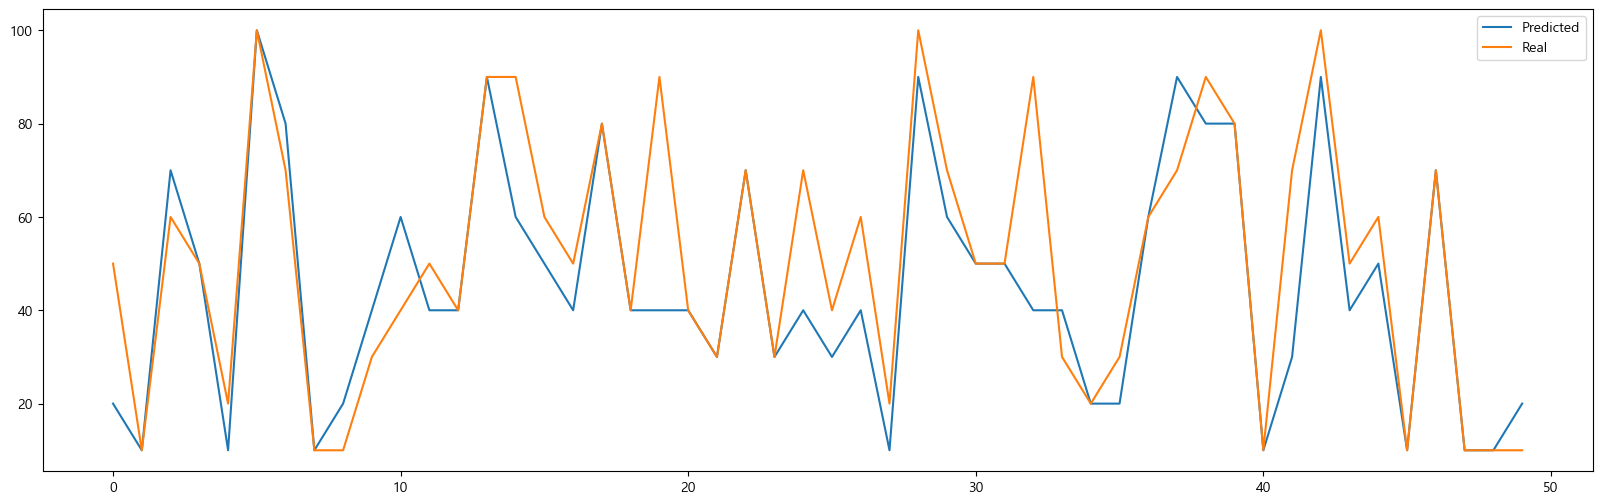

튜닝한 결정 트리 분류 모델 2023년 데이터 정확도 : 0.10218978102189781


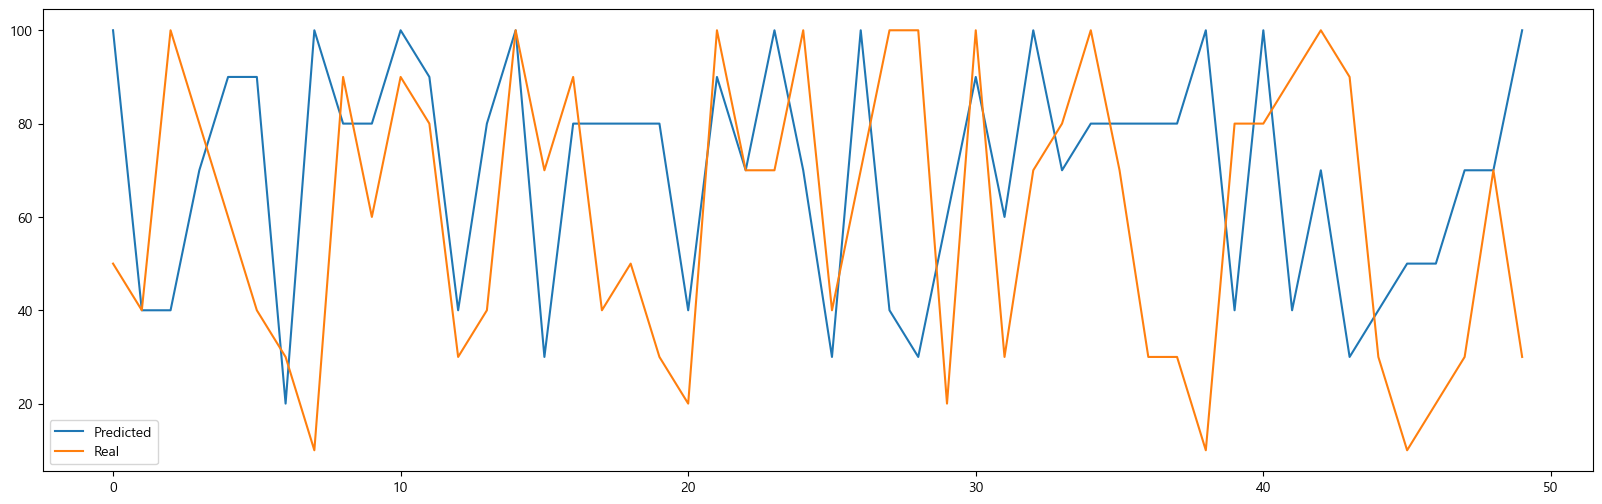

In [13]:
modified_dt_model = model_fit_and_visualize(DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=58, min_samples_split=2), '튜닝한 결정 트리 분류 모델')

#### 괜찮은 것 같기도 하고

## 튜닝한 모델 저장

In [ ]:
import pickle
import os

# save model to file
filePath = 'dt_cl_model'
pickle.dump(modified_dt_model, open(filePath, 'wb'))
print('Model Successfully Saved')